# New approach for O$_3$ analysis over Japan. Part 2

## Init

In [1]:
import urllib.request
import zipfile
import glob, os
import numpy as np
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
# from matplotlib.font_manager import FontProperties
# fp = FontProperties(fname=r'C:\WINDOWS\Fonts\msgothic.ttc', size=5)

## Data processing

### Prefectures of Japan

In [2]:
dic_p = {}
with open("../inp_data/pref.txt", "r", encoding='utf-8') as file:
    next(file)
    for line in file:
        key, jp, eng = line.strip().split("\t")
        dic_p[key] = eng
print(dic_p)

{'1': 'Hokkaido', '2': 'Aomori', '3': 'Iwate', '4': 'Miyagi', '5': 'Akita', '6': 'Yamagata', '7': 'Fukushima', '8': 'Ibaraki', '9': 'Tochigi', '10': 'Gunma', '11': 'Saitama', '12': 'Chiba', '13': 'Tokyo', '14': 'Kanagawa', '15': 'Niigata', '16': 'Toyama', '17': 'Ishikawa', '18': 'Fukui', '19': 'Yamanashi', '20': 'Nagano', '21': 'Gifu', '22': 'Shizuoka', '23': 'Aichi', '24': 'Mie', '25': 'Shiga', '26': 'Kyoto', '27': 'Osaka', '28': 'Hyogo', '29': 'Nara', '30': 'Wakayama', '31': 'Tottori', '32': 'Shimane', '33': 'Okayama', '34': 'Hiroshima', '35': 'Yamaguchi', '36': 'Tokushima', '37': 'Kagawa', '38': 'Ehime', '39': 'Kochi', '40': 'Fukuoka', '41': 'Saga', '42': 'Nagasaki', '43': 'Kumamoto', '44': 'Oita', '45': 'Miyazaki', '46': 'Kagoshima', '47': 'Okinawa'}


### Parameters

In [3]:
d_path = '../inp_data/2009-2017/'
years = [2009, 2017]
pref_max = 47

### Collect df

In [4]:
u_path = d_path + 'uzip/'
frames = []
for yr in range(years[0], years[0]+1, 1):
    s_yr = str(yr)
    for pr in range(1, pref_max+1):
        s_pr = str(pr).zfill(2)
        f_name = 'j' + s_pr + s_yr + '_' + '06.txt'
        f_name = u_path + s_pr + '/' + s_yr + '/' + f_name

        print(f_name)

        # --- read
        df_r = pd.read_csv(f_name, encoding='cp932')
        frames.append(df_r)
df_s = pd.concat(frames)
df_s.drop(columns=['測定項目コード', '測定単位コード'], inplace=True)
df = df_s.copy()
print('Full df len:', len(df_s))

../inp_data/2009-2017/uzip/01/2009/j012009_06.txt
../inp_data/2009-2017/uzip/02/2009/j022009_06.txt
../inp_data/2009-2017/uzip/03/2009/j032009_06.txt
../inp_data/2009-2017/uzip/04/2009/j042009_06.txt
../inp_data/2009-2017/uzip/05/2009/j052009_06.txt
../inp_data/2009-2017/uzip/06/2009/j062009_06.txt
../inp_data/2009-2017/uzip/07/2009/j072009_06.txt
../inp_data/2009-2017/uzip/08/2009/j082009_06.txt
../inp_data/2009-2017/uzip/09/2009/j092009_06.txt
../inp_data/2009-2017/uzip/10/2009/j102009_06.txt
../inp_data/2009-2017/uzip/11/2009/j112009_06.txt
../inp_data/2009-2017/uzip/12/2009/j122009_06.txt
../inp_data/2009-2017/uzip/13/2009/j132009_06.txt
../inp_data/2009-2017/uzip/14/2009/j142009_06.txt
../inp_data/2009-2017/uzip/15/2009/j152009_06.txt
../inp_data/2009-2017/uzip/16/2009/j162009_06.txt
../inp_data/2009-2017/uzip/17/2009/j172009_06.txt
../inp_data/2009-2017/uzip/18/2009/j182009_06.txt
../inp_data/2009-2017/uzip/19/2009/j192009_06.txt
../inp_data/2009-2017/uzip/20/2009/j202009_06.txt


### Add hours data

In [5]:
df_t = df.copy()
df = pd.melt(df_t, id_vars=['測定年度', '測定局コード', '市町村コード', '測定月', '測定日'], 
             value_vars=['01h','02h','03h','04h','05h','06h','07h','08h','09h','10h','11h',
                         '12h','13h','14h','15h','16h','17h','18h','19h','20h','21h','22h','23h','24h'])
df['hour'] = df.apply(lambda row: int(str(row['variable'])[:-1]) - 1, axis=1)

### Cut wrong days, add index and drop columns

In [6]:
df_t = df.copy()
df_t['index'] = pd.to_datetime(dict(year=df_t.測定年度, month=df_t.測定月, 
                                    day=df_t.測定日, hour=df_t.hour), errors='coerce')
df_t.dropna(inplace=True)
df_t.drop(columns=['variable'], inplace=True)
df_t.set_index('index', inplace=True)
df_t.rename(columns={'value':'OX'}, inplace=True)

### remove undef (~9999)

In [7]:
df_t['OX'] = df_t.OX.apply(lambda x: x if x < 9900 else np.nan)
df_t.dropna(inplace=True)

### Remove Japanese names

In [8]:
df_t.rename(columns={'測定局コード':'site_id'}, inplace=True)
df_t.rename(columns={'市町村コード':'city_id'}, inplace=True)
df_t.rename(columns={'測定年度':'year'}, inplace=True)
df_t.rename(columns={'測定月':'month'}, inplace=True)
df_t.rename(columns={'測定日':'day'}, inplace=True)

### Add prefecture names

In [9]:
df_t['pref'] = df_t.apply(lambda row: str(row['site_id'])[:-6], axis=1)
df_t['pref'] = df_t['pref'].map(dic_p)

In [10]:
print(df_t.head())
print(df_t.tail())
df = df_t.copy()

            year  site_id city_id  month  day    OX  hour      pref
index                                                              
2009-04-01  2009  1101010     101      4    1  15.0     0  Hokkaido
2009-04-02  2009  1101010     101      4    2   7.0     0  Hokkaido
2009-04-03  2009  1101010     101      4    3   6.0     0  Hokkaido
2009-04-04  2009  1101010     101      4    4   7.0     0  Hokkaido
2009-04-05  2009  1101010     101      4    5  57.0     0  Hokkaido
                     year   site_id city_id  month  day    OX  hour     pref
index                                                                       
2009-03-27 23:00:00  2009  47322010     213      3   27  58.0    23  Okinawa
2009-03-28 23:00:00  2009  47322010     213      3   28  64.0    23  Okinawa
2009-03-29 23:00:00  2009  47322010     213      3   29  63.0    23  Okinawa
2009-03-30 23:00:00  2009  47322010     213      3   30  65.0    23  Okinawa
2009-03-31 23:00:00  2009  47322010     213      3   31  62.0 

## Analysis

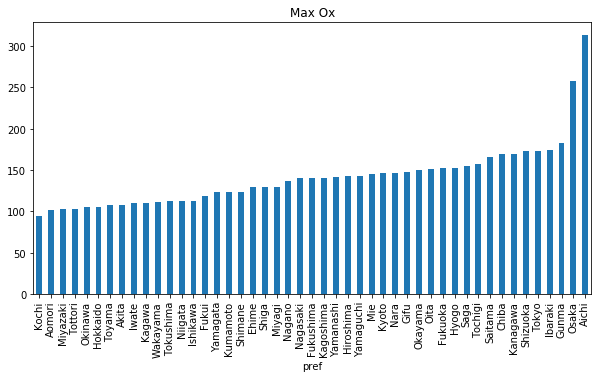

In [11]:
df_t = df.copy()
df_t.groupby('pref')['OX'].max().sort_values().plot(kind='bar', title='Max Ox', figsize=(10,5)); 

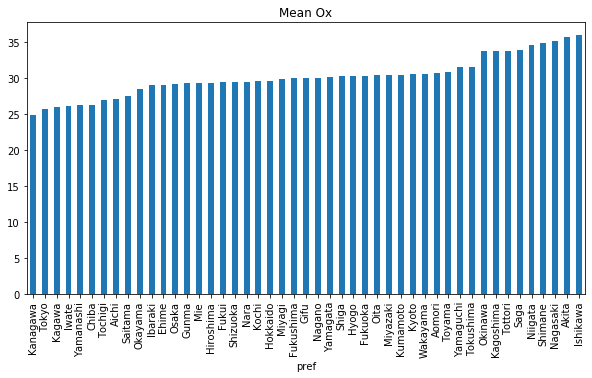

In [12]:
df_t.groupby('pref')['OX'].mean().sort_values().plot(kind='bar', title='Mean Ox', figsize=(10,5));

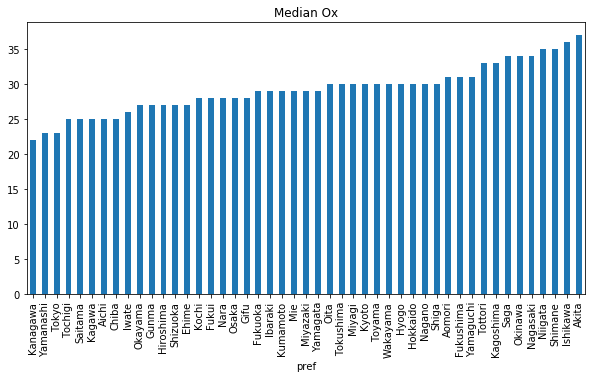

In [13]:
df_t.groupby('pref')['OX'].median().sort_values().plot(kind='bar', title='Median Ox', figsize=(10,5));

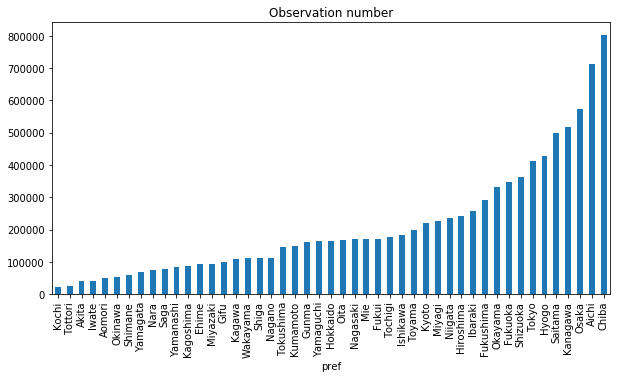

In [14]:
df_t.groupby('pref').size().sort_values().plot(kind='bar', title='Observation number', figsize=(10,5));

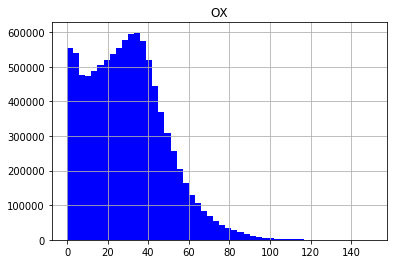

In [15]:
df_t.hist('OX', bins=50, range=[0, 150], facecolor='blue', align='mid', figsize=(6,4));

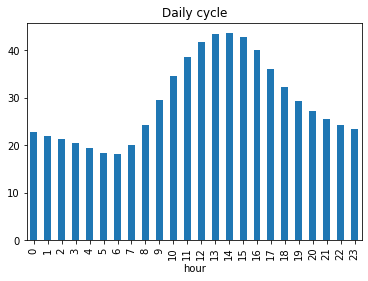

In [16]:
df_t.groupby('hour')['OX'].mean().plot(kind='bar', title='Daily cycle', figsize=(6,4));

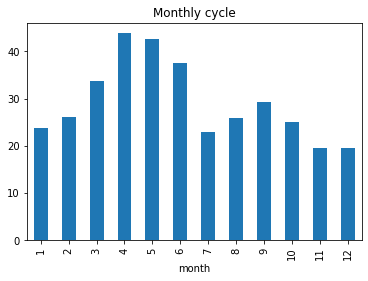

In [17]:
df_t.groupby('month')['OX'].mean().plot(kind='bar', title='Monthly cycle', figsize=(6,4));

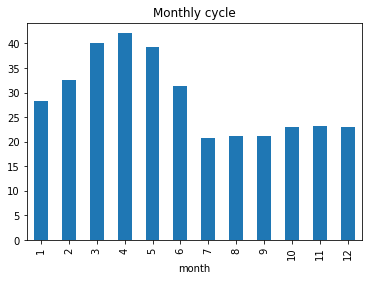

In [18]:
df = df_t.loc[df_t['pref'] == 'Hokkaido']
df.groupby('month')['OX'].mean().plot(kind='bar', title='Monthly cycle', figsize=(6,4));

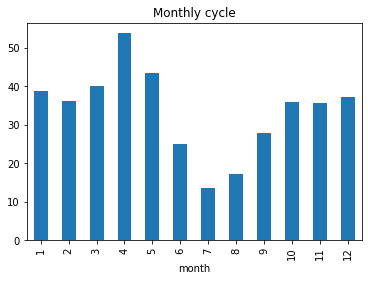

In [19]:
df = df_t.loc[df_t['pref'] == 'Okinawa']
df.groupby('month')['OX'].mean().plot(kind='bar', title='Monthly cycle', figsize=(6,4));

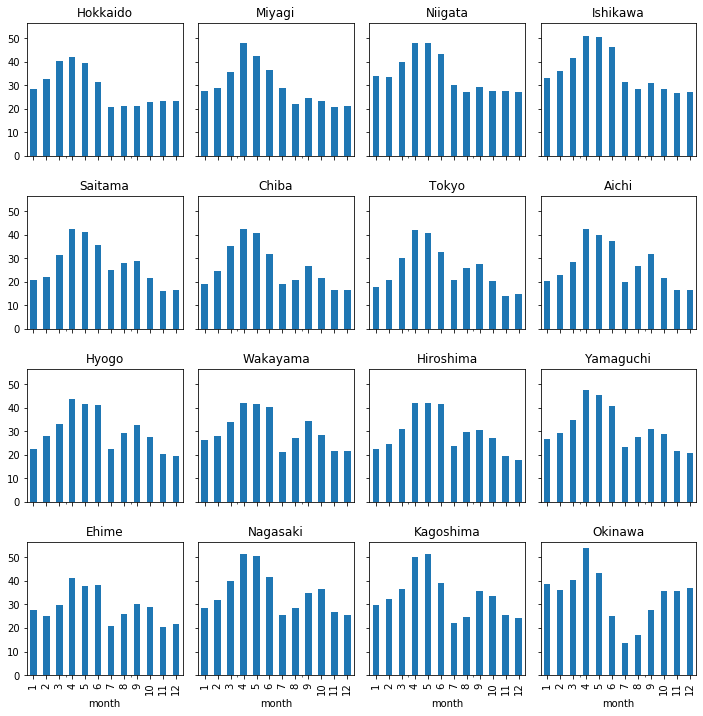

In [20]:
prf = ['Hokkaido', 'Miyagi', 'Niigata', 'Ishikawa', 
       'Saitama', 'Chiba', 'Tokyo', 'Aichi', 
       'Hyogo', 'Wakayama', 'Hiroshima', 'Yamaguchi', 
       'Ehime', 'Nagasaki', 'Kagoshima', 'Okinawa']
fig, axx = plt.subplots(4, 4, figsize=(12,12), sharex='all', sharey='all')
fig.subplots_adjust(hspace=0.3, wspace=0.1)
for j in range(0, len(prf)):
    df_t.loc[df_t['pref'] == prf[j]].groupby('month')['OX'].mean().plot(kind='bar', title=prf[j], ax=axx.flat[j]);

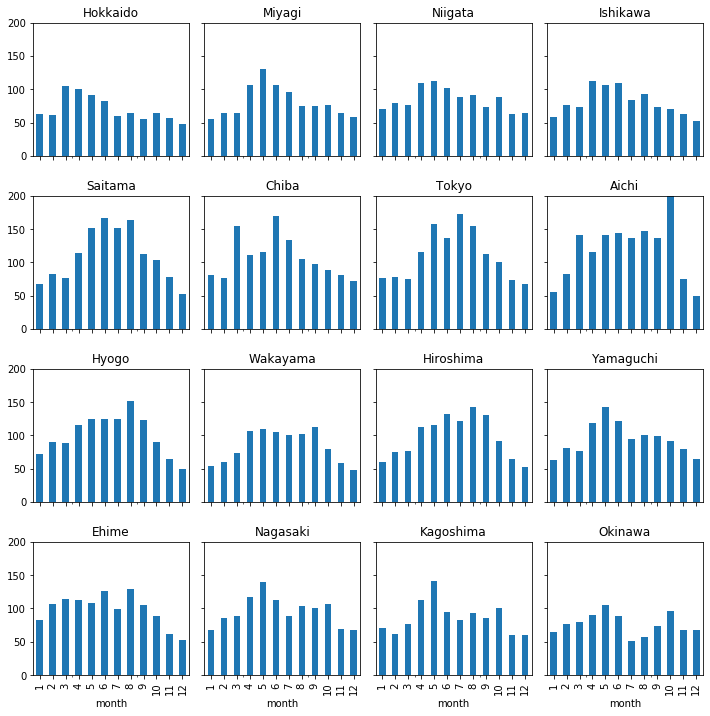

In [21]:
fig, axx = plt.subplots(4, 4, figsize=(12,12), sharex='all', sharey='all')
fig.subplots_adjust(hspace=0.3, wspace=0.1)
for j in range(0, len(prf)):
    df_t.loc[df_t['pref'] == prf[j]].groupby('month')['OX'].max().plot(kind='bar', title=prf[j], ax=axx.flat[j]);
    axx.flat[j].set_ylim(0, 200)

### Kanto

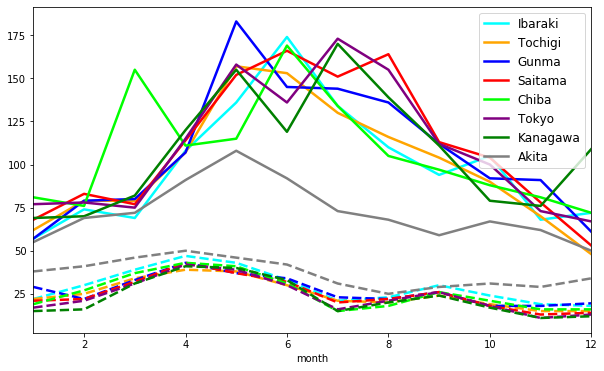

In [22]:
prf = ['Ibaraki', 'Tochigi', 'Gunma', 'Saitama', 'Chiba', 'Tokyo', 'Kanagawa', 'Akita']
fig, axx = plt.subplots(figsize=(10,6))
f_size = 12
colors = ['Cyan', 'Orange', 'Blue', 'Red', 'Lime', 'Purple', 'Green', 'Grey']
for j in range(0, len(prf)):
    df_t.loc[df_t['pref'] == prf[j]].groupby('month')['OX'].max().plot(
        kind='line', lw=2.5, ls='-', color=colors[j], label=prf[j], ax=axx);
    df_t.loc[df_t['pref'] == prf[j]].groupby('month')['OX'].median().plot(
        kind='line', lw=2.5, ls='--', color=colors[j], label='', ax=axx);
axx.legend(loc="upper right", ncol=1, fontsize= f_size)


In [23]:
print(dic_p)

{'1': 'Hokkaido', '2': 'Aomori', '3': 'Iwate', '4': 'Miyagi', '5': 'Akita', '6': 'Yamagata', '7': 'Fukushima', '8': 'Ibaraki', '9': 'Tochigi', '10': 'Gunma', '11': 'Saitama', '12': 'Chiba', '13': 'Tokyo', '14': 'Kanagawa', '15': 'Niigata', '16': 'Toyama', '17': 'Ishikawa', '18': 'Fukui', '19': 'Yamanashi', '20': 'Nagano', '21': 'Gifu', '22': 'Shizuoka', '23': 'Aichi', '24': 'Mie', '25': 'Shiga', '26': 'Kyoto', '27': 'Osaka', '28': 'Hyogo', '29': 'Nara', '30': 'Wakayama', '31': 'Tottori', '32': 'Shimane', '33': 'Okayama', '34': 'Hiroshima', '35': 'Yamaguchi', '36': 'Tokushima', '37': 'Kagawa', '38': 'Ehime', '39': 'Kochi', '40': 'Fukuoka', '41': 'Saga', '42': 'Nagasaki', '43': 'Kumamoto', '44': 'Oita', '45': 'Miyazaki', '46': 'Kagoshima', '47': 'Okinawa'}


### North to South

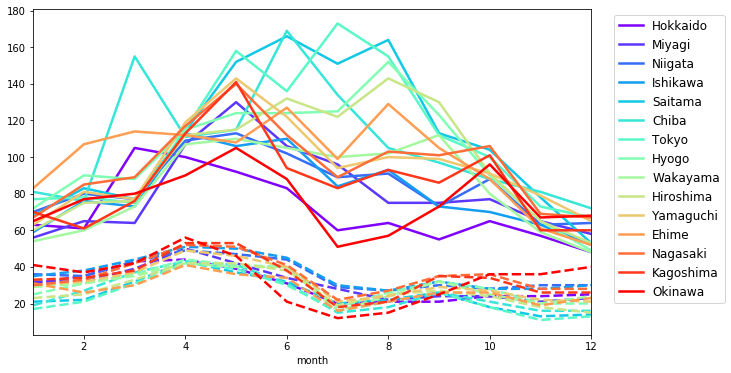

In [24]:
prf = ['Hokkaido', 'Miyagi', 'Niigata', 'Ishikawa', 
       'Saitama', 'Chiba', 'Tokyo', 
       'Hyogo', 'Wakayama', 'Hiroshima', 'Yamaguchi', 
       'Ehime', 'Nagasaki', 'Kagoshima', 'Okinawa']
fig, axx = plt.subplots(figsize=(10,6))
f_size = 12
colors = ['Cyan', 'Orange', 'Blue', 'Red', 'Lime', 'Purple', 'Green', 'Grey', 
          'Cyan', 'Orange', 'Blue', 'Red', 'Lime', 'Purple', 'Green', 'Grey']

number = len(prf)
cmap = plt.get_cmap('rainbow')
colors = [cmap(i) for i in np.linspace(0, 1, number)]

for j in range(0, len(prf)):
    df_t.loc[df_t['pref'] == prf[j]].groupby('month')['OX'].max().plot(
        kind='line', lw=2.5, ls='-', color=colors[j], label=prf[j], ax=axx);
    df_t.loc[df_t['pref'] == prf[j]].groupby('month')['OX'].median().plot(
        kind='line', lw=2.5, ls='--', color=colors[j], label='', ax=axx);
axx.legend(loc="upper right", ncol=1, fontsize= f_size, bbox_to_anchor=(1.25, 1))

### Regions

In [28]:
df = df_t.copy()

def ifef(col):
    if col in ['Hokkaido']:
        return 'Hokkaido'
    if col in ['Aomori', 'Iwate', 'Miyagi', 'Akita', 'Yamagata', 'Fukushima']:
        return 'Tohoku'
    if col in ['Ibaraki', 'Tochigi', 'Gunma', 'Saitama', 'Chiba', 'Tokyo', 'Kanagawa']:
        return 'Kanto'
    if col in ['Niigata', 'Toyama', 'Ishikawa', 'Fukui', 'Yamanashi', 'Nagano', 'Gifu', 
               'Shizuoka', 'Aichi']:
        return 'Chubu'
    if col in ['Mie', 'Shiga', 'Kyoto', 'Osaka', 'Hyogo', 'Nara', 'Wakayama']:
        return 'Kansai'
    if col in ['Tottori', 'Shimane', 'Okayama', 'Hiroshima', 'Yamaguchi']:
        return 'Chugoku'
    if col in ['Tokushima', 'Kagawa', 'Ehime', 'Kochi']:
        return 'Shikoku'
    if col in ['Fukuoka', 'Saga', 'Nagasaki', 'Kumamoto', 'Oita', 'Miyazaki', 
               'Kagoshima', 'Okinawa']:
        return 'Kyushu'
    
df['region'] = df['pref'].apply(ifef)

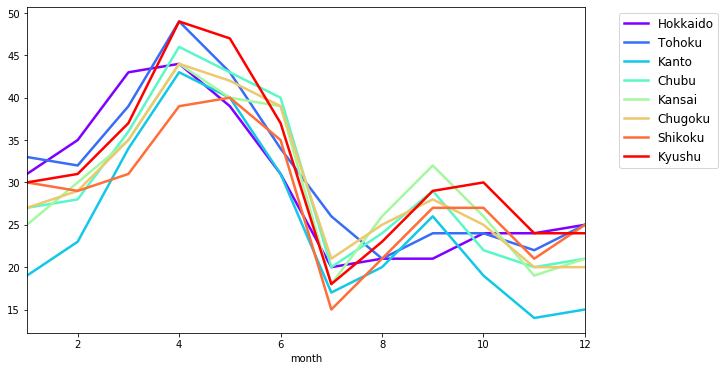

In [34]:
reg = ['Hokkaido', 'Tohoku', 'Kanto', 'Chubu', 'Kansai', 'Chugoku', 'Shikoku', 'Kyushu']
fig, axx = plt.subplots(figsize=(10,6))
f_size = 12
number = len(reg)
cmap = plt.get_cmap('rainbow')
colors = [cmap(i) for i in np.linspace(0, 1, number)]

for j in range(0, len(reg)):
    df.loc[df['region'] == reg[j]].groupby('month')['OX'].median().plot(
        kind='line', lw=2.5, ls='-', color=colors[j], label=reg[j], ax=axx)
axx.legend(loc="upper right", ncol=1, fontsize= f_size, bbox_to_anchor=(1.2, 1));

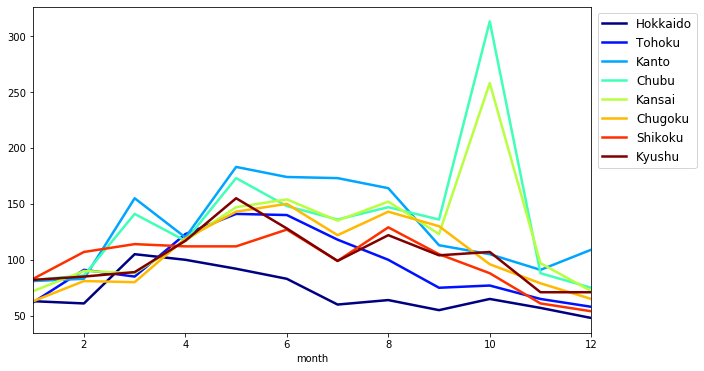

In [38]:
fig, axx = plt.subplots(figsize=(10,6))
f_size = 12
number = len(reg)
cmap = plt.get_cmap('jet')
colors = [cmap(i) for i in np.linspace(0, 1, number)]

for j in range(0, len(reg)):
    df.loc[df['region'] == reg[j]].groupby('month')['OX'].max().plot(
        kind='line', lw=2.5, ls='-', color=colors[j], label=reg[j], ax=axx)
axx.legend(loc="upper right", ncol=1, fontsize= f_size, bbox_to_anchor=(1.2, 1));

In [29]:
print(df.head())
print(df.tail())

            year  site_id city_id  month  day    OX  hour      pref    region
index                                                                        
2009-04-01  2009  1101010     101      4    1  15.0     0  Hokkaido  Hokkaido
2009-04-02  2009  1101010     101      4    2   7.0     0  Hokkaido  Hokkaido
2009-04-03  2009  1101010     101      4    3   6.0     0  Hokkaido  Hokkaido
2009-04-04  2009  1101010     101      4    4   7.0     0  Hokkaido  Hokkaido
2009-04-05  2009  1101010     101      4    5  57.0     0  Hokkaido  Hokkaido
                     year   site_id city_id  month  day    OX  hour     pref  \
index                                                                          
2009-03-27 23:00:00  2009  47322010     213      3   27  58.0    23  Okinawa   
2009-03-28 23:00:00  2009  47322010     213      3   28  64.0    23  Okinawa   
2009-03-29 23:00:00  2009  47322010     213      3   29  63.0    23  Okinawa   
2009-03-30 23:00:00  2009  47322010     213      3   3

In [39]:
df.to_pickle('../out_data/jap_ox_2009')